In [1]:
import numpy as np 
from Environment import Easy21
import matplotlib.pyplot as plt
from utils import *

<h2>Theoretical value function</h2>

In [2]:
##Action value
value_star = value_iteration(1000)

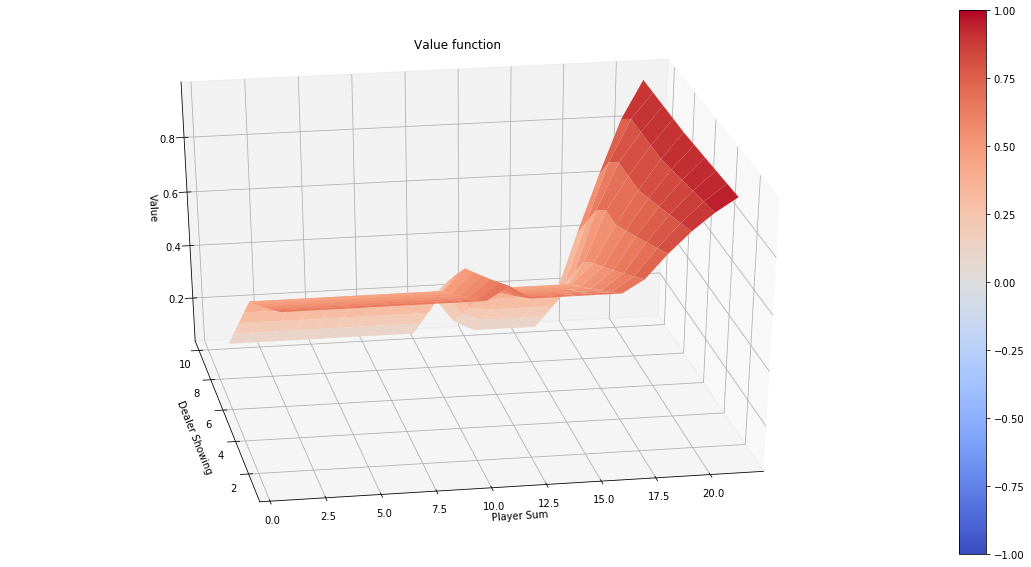

In [3]:
plot_value_function(value_star, degree= -100, cm = plt.cm.coolwarm)

<h2>Params</h2>

In [7]:
#Params
N0 = 100
discount_factor = 1


<h2>Monte-Carlo</h2>

In [3]:

##Monte Carlo
iterations_MC = int(1e6)
action_montecarlo = montecarlo(iterations_MC, N0, discount_factor)

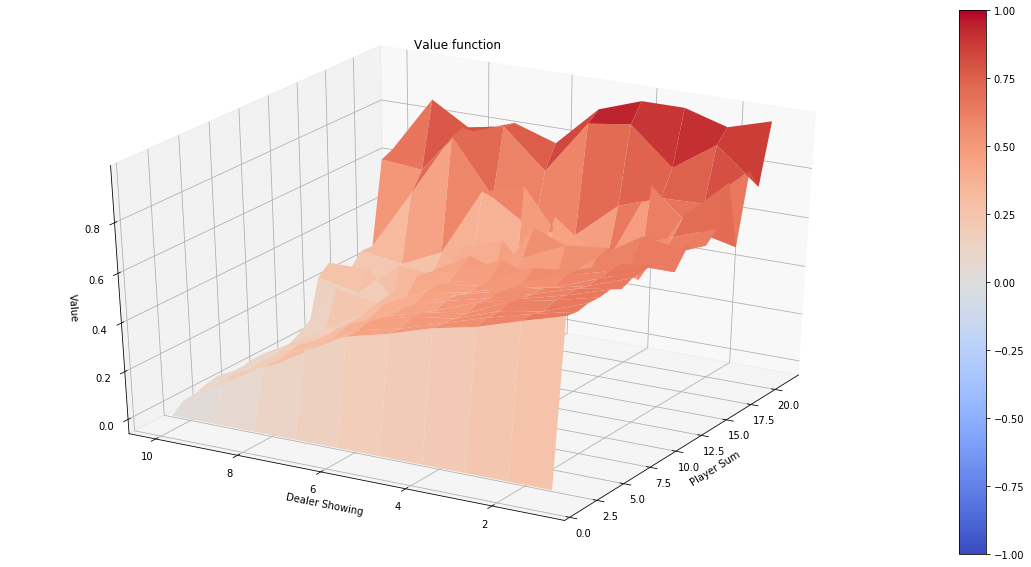

In [4]:
plt.clf() 
plot_value_function(get_value(action_montecarlo), degree= -150, title = "Monte-Carlo", cm = plt.cm.coolwarm)


<h2>TD Lambda</h2>

<h3>Comparing performance for different lambdas</h3>

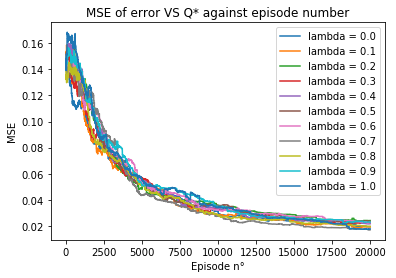

In [19]:
##TD
iterations = int(2e4)
lambdas = [i/10 for i in range(11)]
MSEs_all = []
plt.clf()
for i in range(len(lambdas)):
    MSEs,action_value= td_lambda_backward_view2(iterations, N0, discount_factor, lambdas[i], value_star)
    MSEs_all.append(MSEs)
episodes = [i for i in range(iterations)]

for k in range(len(lambdas)):
    plt.plot(episodes, MSEs_all[k])
    
plt.xlabel("Episode n°")
plt.ylabel("MSE")
plt.legend(["lambda = " + str(Lambda) for Lambda in lambdas])
plt.title("MSE of error VS Q* against episode number")

plt.show()

<h3>Plot value function for a specific lambda</h3>

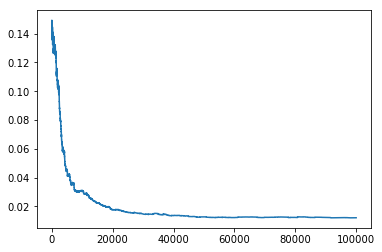

In [13]:
lambda1 = 0.5
discount_factor= 1.0
iterations = int(1e5)

plt.clf()
MSEs, av = td_lambda_backward_view2(iterations, N0, discount_factor, lambda1, value_star)
plt.plot([i for i in range(iterations)], MSEs)
plt.show()

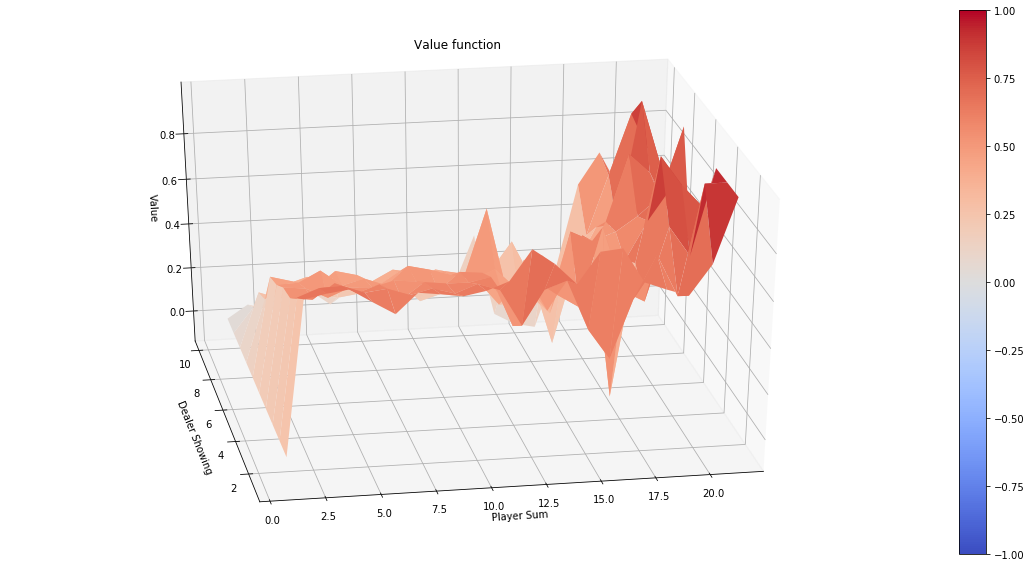

In [17]:
plt.clf()
plot_value_function(get_value(av), degree= -100, cm = plt.cm.coolwarm)

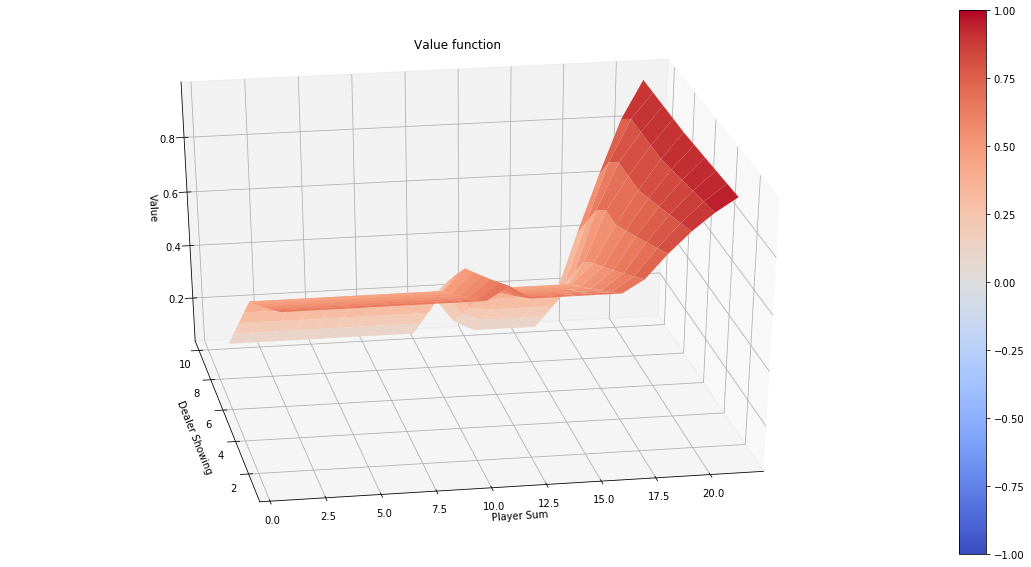

In [18]:
plot_value_function(value_star, degree= -100, cm = plt.cm.coolwarm)

In [9]:
def policy_epsilon_greedy(N0, dealer, player_sum, action_value, number_action_value):
        """Pick action epsilon-greedily"""
        action_value_ij = action_value[dealer-1, player_sum]
        epsilon_t = N0 / (N0 + sum(number_action_value[dealer-1, player_sum,:]) )
        p = np.random.binomial(1,epsilon_t)
        max_index = np.argmax(action_value_ij)
        min_index = np.argmin(action_value_ij)
        if max_index!=min_index:
            if p == 0:
                index_action = max_index

            else:
                index_action = min_index
        else:
             index_action = np.random.binomial(1,0.5)
        return index_action

In [11]:
def td_lambda_backward_view2(iterations, N0, discount_factor, Lambda, value_star):
    MSEs = []
    actions = ["Hit", "Stick"]
    action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    number_action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    eligibility_traces = None 

    for it in range(iterations):
        
        """plays one episode"""
        eligibility_traces = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
        game = Easy21()
        visits = []
        ##Action chosen epsilon-greedily
        first_state = game.state
        index_action = policy_epsilon_greedy(N0, first_state["dealer"], first_state["player_sum"], action_value, number_action_value)
        """plays game epsilon-greedily"""
        while game.isTerminal == False:
            
            last_state = game.state
            dealer, player_sum = last_state["dealer"], last_state["player_sum"]
            
           
            
            pick_action = actions[index_action]
            number_action_value[dealer-1, player_sum, index_action]+=1
            alpha = 1/number_action_value[dealer-1, player_sum, index_action]
            
            _,reward = game.step(pick_action)
            eligibility_traces[dealer-1, player_sum, index_action]+=1

            if game.isTerminal == False:
                next_state = game.state
                next_dealer , next_player_sum = next_state["dealer"], next_state["player_sum"]
                next_index_action = policy_epsilon_greedy(N0, next_dealer, next_player_sum, action_value, number_action_value)
                target = reward + discount_factor * action_value[next_dealer-1, next_player_sum, next_index_action]
                index_action = next_index_action

            else: 
                target = reward
            delta = target - action_value[dealer-1, player_sum, index_action]
            delta_tot = eligibility_traces * delta  * alpha
            ##We update all states and actions
            action_value += delta_tot
             
            eligibility_traces = discount_factor * Lambda * eligibility_traces
        """episode ended"""
       
        error_episode = np.linalg.norm(get_value(action_value)-value_star)**2 / (2 * 22 * 10)
        MSEs.append(error_episode)
    return MSEs, action_value

In [30]:
def td_lambda_backward_view(iterations, N0, discount_factor, Lambda, Q_s_a_star):
    MSEs = []
    actions = ["Hit", "Stick"]
    action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    number_action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    eligibility_traces = None 

    for it in range(iterations):
        
        """plays one episode"""
        eligibility_traces = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
        game = Easy21()
        visits = []
        
        """plays game epsilon-greedily"""
        while game.isTerminal == False:
            
            last_state = game.state
            dealer, player_sum = last_state["dealer"], last_state["player_sum"]
            action_value_ij = action_value[dealer-1, player_sum]


            ##Pick action epsilon-greedily
            epsilon_t = N0 / (N0 + sum(number_action_value[dealer-1, player_sum,:]) )
            p = np.random.binomial(1,epsilon_t)
            max_index = np.argmax(action_value_ij)
            min_index = np.argmin(action_value_ij)
            if max_index!=min_index:
                if p == 0:
                    index_action = max_index

                else:
                    index_action = min_index
            else:
                 index_action = np.random.binomial(1,0.5)

           

            pick_action = actions[index_action]
            _,reward = game.step(pick_action)
            visits.append([last_state, index_action, reward])
            number_action_value[dealer-1, player_sum, index_action]+=1
        """episode ended"""

      

        for k, step in enumerate(visits):
            [state, action, reward] = step
            
            dealer, player_sum = state["dealer"], state["player_sum"]
            eligibility_traces = discount_factor * Lambda * eligibility_traces
            eligibility_traces[dealer-1, player_sum, index_action]+=1.0
            
            if k<len(visits)-1:
                [next_state, next_action, next_reward] = visits[k+1]
                next_dealer, next_player_sum = next_state["dealer"], next_state["player_sum"]
                delta_t = reward + discount_factor * action_value[next_dealer-1, next_player_sum, next_action] - action_value[dealer-1, player_sum, action]
            else:
                delta_t = reward - action_value[dealer-1, player_sum, action]
            delta_action_value = delta_t * eligibility_traces[dealer-1, player_sum, action] / number_action_value[dealer-1, player_sum, action]
            action_value[dealer-1, player_sum, action] += delta_action_value
        
        error_episode = np.linalg.norm(action_value-Q_s_a_star)**2 / (2 * 22 * 10)
        #print(error_episode)
        MSEs.append(error_episode)
        
    return MSEs, action_value

In [2]:
def td_lambda_forward_view(iterations, N0, discount_factor, Lambda, Q_s_a_star):
    MSEs = []
    actions = ["Hit", "Stick"]
    action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    number_action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    
    for it in range(iterations):
        """plays one episode"""
        game = Easy21()
        visits = []
        while game.isTerminal == False:
            last_state = game.state
            dealer, player_sum = last_state["dealer"], last_state["player_sum"]
            action_value_ij = action_value[dealer-1, player_sum]


            ##Pick action epsilon-greedily
            epsilon_t = N0 / (N0 + sum(number_action_value[dealer-1, player_sum,:]) )
            p = np.random.binomial(1,epsilon_t)
            max_index = np.argmax(action_value_ij)
            min_index = np.argmin(action_value_ij)
            if max_index!=min_index:
                if p == 0:
                    index_action = max_index

                else:
                    index_action = min_index
            else:
                 index_action = np.random.binomial(1,0.5)



            pick_action = actions[index_action]
            _,reward = game.step(pick_action)
            visits.append([last_state, index_action, reward])
            number_action_value[dealer-1, player_sum, index_action]+=1

        qt_lambda = 0.0
        qt_lambda_k = 0.0
        cumulated_reward= 0.0 
        """episode ended"""
        for k, step in enumerate(visits[:-1]):
            [state, action, reward] = step
            dealer, player_sum = state["dealer"], state["player_sum"]
            
            [next_state, next_action, next_reward] = visits[k+1]
            discounted_reward  = reward * discount_factor**k
            cumulated_reward += discounted_reward
            
            qt_lambda_k = discounted_reward + discount_factor**(k+1) * action_value[next_state["dealer"]-1, next_state["player_sum"], next_action]
            
            qt_lambda += Lambda **k * qt_lambda_k
        ##Last step
        [state, action, reward] = visits[-1]
        dealer, player_sum = state["dealer"], state["player_sum"]
        qt_lambda += Lambda**(len(visits)-1) * (cumulated_reward +   discount_factor**(len(visits)-1) * reward )
        qt_lambda = (1.0-Lambda)*qt_lambda
        print(visits)
        print(qt_lambda)

        for step in visits:
            [state, action, reward] = step
            dealer, player_sum = state["dealer"], state["player_sum"]
            delta_action_value = (qt_lambda - action_value[dealer-1, player_sum, action] ) / number_action_value[dealer-1, player_sum, action]
            action_value[dealer-1, player_sum, action] += delta_action_value
        
        error_episode = np.linalg.norm(action_value-Q_s_a_star)**2 / (2 * 22 * 10)
        #print(error_episode)
        MSEs.append(error_episode)
        
    return MSEs, action_value